第1步：能量 = 0.000000 Ha
第2步：能量 = -0.814042 Ha
第3步：能量 = -2.322804 Ha
第4步：能量 = -2.934076 Ha
第5步：能量 = -3.060402 Ha
第6步：能量 = -3.220121 Ha
第7步：能量 = -3.323699 Ha
第8步：能量 = -3.420903 Ha
第9步：能量 = -3.495938 Ha
第10步：能量 = -3.563053 Ha
第11步：能量 = -3.618022 Ha
第12步：能量 = -3.666660 Ha
第13步：能量 = -3.707604 Ha
第14步：能量 = -3.743760 Ha
第15步：能量 = -3.774663 Ha
第16步：能量 = -3.801962 Ha
第17步：能量 = -3.825516 Ha
第18步：能量 = -3.846344 Ha
第19步：能量 = -3.864427 Ha
第20步：能量 = -3.880433 Ha
第21步：能量 = -3.894391 Ha
第22步：能量 = -3.906756 Ha
第23步：能量 = -3.917574 Ha
第24步：能量 = -3.927164 Ha
第25步：能量 = -3.935574 Ha
第26步：能量 = -3.943034 Ha
第27步：能量 = -3.949587 Ha
第28步：能量 = -3.955402 Ha
第29步：能量 = -3.960518 Ha
第30步：能量 = -3.965059 Ha
第31步：能量 = -3.969058 Ha
第32步：能量 = -3.972609 Ha
第33步：能量 = -3.975738 Ha
第34步：能量 = -3.978518 Ha
第35步：能量 = -3.980969 Ha
第36步：能量 = -3.983146 Ha
第37步：能量 = -3.985067 Ha
第38步：能量 = -3.986773 Ha
第39步：能量 = -3.988280 Ha
第40步：能量 = -3.989618 Ha
第41步：能量 = -3.990799 Ha
第42步：能量 = -3.991849 Ha
第43步：能量 = -3.992776 Ha
第44步：能量 = -3.993600 H

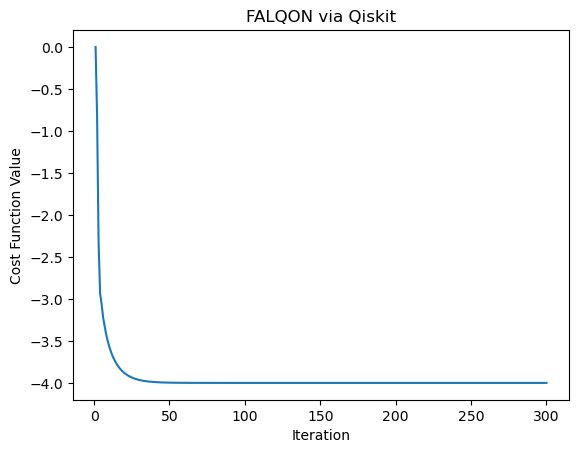

In [25]:
from qiskit.quantum_info import SparsePauliOp

def build_cost_h(n):
    paulis = ['Z' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_driver_h(n):
    paulis = ['X' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_comm_h(n):
    paulis = ['Y' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [2.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

from qiskit.circuit import QuantumCircuit
from numpy import pi

def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # reverse Qiskit convention
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i+1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i+1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)

def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))


from qiskit.quantum_info import Statevector

def build_statevector(beta_list, cost_h, driver_h, delta_t, n_qubits):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.h(i)

    for beta_k in beta_list:
        apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t)

    state = Statevector.from_instruction(qc)
    return state, qc


def falqon_qiskit(n_qubits, n_layers, beta_1, delta_t):
    cost_h = build_cost_h(n_qubits)
    driver_h = build_driver_h(n_qubits)
    comm_h = build_comm_h(n_qubits)

    beta = [beta_1]
    energies = []
    i=1
    for _ in range(n_layers):
        
        state, _ = build_statevector(beta, cost_h, driver_h, delta_t, n_qubits)
        next_beta = -1  * state.expectation_value(comm_h).real
        beta.append(next_beta)

        energy = state.expectation_value(cost_h).real
        energies.append(energy)

        print(f"第{i}步：能量 = {energy:.6f} Ha")
        i=i+1
    return beta, energies


import matplotlib.pyplot as plt

n_qubits = 4
n = 300
beta_1 = 0.0
delta_t = 0.03

res_beta, res_energies = falqon_qiskit(n_qubits, n, beta_1, delta_t)

plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON via Qiskit")
plt.show()




构建哈密顿量完成
SparsePauliOp(['ZIII', 'ZIII', 'ZIII', 'ZIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
SparsePauliOp(['XIII', 'XIII', 'XIII', 'XIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
SparsePauliOp(['YIII', 'YIII', 'YIII', 'YIII'],
              coeffs=[2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j])
第1步：能量 = -0.000000 Ha
第2步：能量 = -0.025289 Ha
第3步：能量 = -0.095416 Ha
第4步：能量 = -0.219622 Ha
第5步：能量 = -0.394469 Ha
第6步：能量 = -0.604367 Ha
第7步：能量 = -0.825155 Ha
第8步：能量 = -1.030025 Ha
第9步：能量 = -1.196207 Ha
第10步：能量 = -1.310519 Ha
第11步：能量 = -1.372218 Ha
第12步：能量 = -1.392571 Ha
第13步：能量 = -1.391572 Ha
第14步：能量 = -1.392888 Ha
第15步：能量 = -1.418315 Ha
第16步：能量 = -1.482901 Ha
第17步：能量 = -1.591702 Ha
第18步：能量 = -1.738833 Ha
第19步：能量 = -1.909110 Ha
第20步：能量 = -2.081950 Ha
第21步：能量 = -2.236576 Ha
第22步：能量 = -2.357104 Ha
第23步：能量 = -2.436116 Ha
第24步：能量 = -2.475856 Ha
第25步：能量 = -2.486965 Ha
第26步：能量 = -2.485360 Ha
第27步：能量 = -2.488198 Ha
第28步：能量 = -2.509902 Ha
第29步：能量 = -2.559099 Ha
第30步：能量 = -2.637

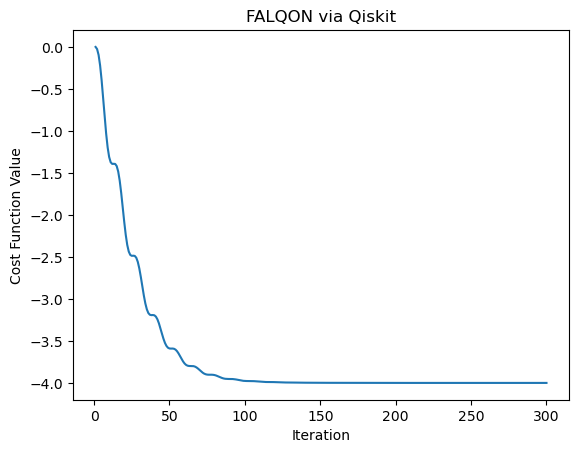

In [11]:
from qiskit.quantum_info import SparsePauliOp

def build_cost_h(n):
    paulis = ['Z' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_driver_h(n):
    paulis = ['X' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_comm_h(n):
    paulis = ['Y' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [2.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

from qiskit.circuit import QuantumCircuit
from numpy import pi

def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # reverse Qiskit convention
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i+1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i+1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)

def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))


from qiskit.quantum_info import Statevector

from qiskit import transpile

def build_statevector(beta_list, cost_h, driver_h, delta_t, n_qubits, basis_gates=None):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.h(i)

    for beta_k in beta_list:
        apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t)

    if basis_gates is not None:
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

    state = Statevector.from_instruction(qc)
    return state, qc

from collections import Counter

def falqon_qiskit(n_qubits, n_layers, beta_1, delta_t, basis_gates=None):
    cost_h = build_cost_h(n_qubits)
    driver_h = build_driver_h(n_qubits)
    comm_h = build_comm_h(n_qubits)
    print("构建哈密顿量完成")
    print(cost_h)
    print(driver_h)
    print(comm_h)    


    beta = [beta_1]
    energies = []
    total_gate_counts = Counter()

    for i in range(n_layers):
        state, qc = build_statevector(beta, cost_h, driver_h, delta_t, n_qubits, basis_gates)
        
        # 累加门计数
        total_gate_counts += Counter(qc.count_ops())

        energy = state.expectation_value(cost_h).real
        next_beta = -1 * delta_t * state.expectation_value(comm_h).real

        beta.append(next_beta)
        energies.append(energy)
        print(f"第{i+1}步：能量 = {energy:.6f} Ha")

    return beta, energies, total_gate_counts



import matplotlib.pyplot as plt

n_qubits = 4
n = 300
beta_1 = 0.0
delta_t = 0.03
basis = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

 # 例如超导平台的标准 gate set

res_beta, res_energies, total_gate_counts = falqon_qiskit(
    n_qubits=n_qubits,
    n_layers=n,
    beta_1=beta_1,
    delta_t=delta_t,
    basis_gates=basis
)

# 输出门统计
print("\n📊 迭代全过程中总基础门统计：")
for gate, count in total_gate_counts.items():
    print(f"{gate}: {count}")

# 绘图
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON via Qiskit")
plt.show()



第1步：能量 = 0.000000 Ha
第2步：能量 = -0.000413 Ha
第3步：能量 = -0.001648 Ha
第4步：能量 = -0.004099 Ha
第5步：能量 = -0.008145 Ha
第6步：能量 = -0.014141 Ha
第7步：能量 = -0.022414 Ha
第8步：能量 = -0.033257 Ha
第9步：能量 = -0.046927 Ha
第10步：能量 = -0.063638 Ha
第11步：能量 = -0.083559 Ha
第12步：能量 = -0.106813 Ha
第13步：能量 = -0.133471 Ha
第14步：能量 = -0.163555 Ha
第15步：能量 = -0.197033 Ha
第16步：能量 = -0.233823 Ha
第17步：能量 = -0.273792 Ha
第18步：能量 = -0.316756 Ha
第19步：能量 = -0.362489 Ha
第20步：能量 = -0.410719 Ha
第21步：能量 = -0.461135 Ha
第22步：能量 = -0.513394 Ha
第23步：能量 = -0.567124 Ha
第24步：能量 = -0.621929 Ha
第25步：能量 = -0.677397 Ha
第26步：能量 = -0.733108 Ha
第27步：能量 = -0.788636 Ha
第28步：能量 = -0.843562 Ha
第29步：能量 = -0.897476 Ha
第30步：能量 = -0.949984 Ha
第31步：能量 = -1.000717 Ha
第32步：能量 = -1.049333 Ha
第33步：能量 = -1.095525 Ha
第34步：能量 = -1.139024 Ha
第35步：能量 = -1.179604 Ha
第36步：能量 = -1.217083 Ha
第37步：能量 = -1.251327 Ha
第38步：能量 = -1.282251 Ha
第39步：能量 = -1.309821 Ha
第40步：能量 = -1.334048 Ha
第41步：能量 = -1.354997 Ha
第42步：能量 = -1.372775 Ha
第43步：能量 = -1.387536 Ha
第44步：能量 = -1.399475 H

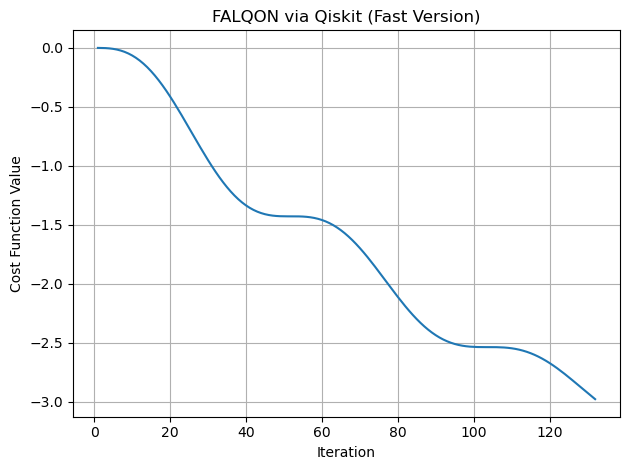

In [12]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector


def build_cost_h(n):
    paulis = ['Z' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_driver_h(n):
    paulis = ['X' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_comm_h(n):
    paulis = ['Y' + 'I'*(n-1-i) + 'I'*i for i in range(n)]
    coeffs = [2.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))


    cost_h = build_cost_h(n_qubits)
    driver_h = build_driver_h(n_qubits)
    comm_h = build_comm_h(n_qubits)  
    
    

from qiskit.circuit import QuantumCircuit
from numpy import pi

from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import QuantumCircuit
from numpy import pi
from collections import Counter
import matplotlib.pyplot as plt

# ----------- Pauli Gate 演化 -------------
def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # Qiskit 是 little-endian
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i + 1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i + 1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)


# ----------- 单层 FALQON 结构 -------------
def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))


# ----------- 优化版主循环 -------------
def falqon_qiskit_fast(n_qubits, n_layers, beta_1, delta_t,basis_gates=None):

    beta = [beta_1]
    energies = []
    total_gate_counts = Counter()

    state = Statevector.from_label("+" * n_qubits)  # 初始全Hadamard态
    qc_layer = QuantumCircuit(n_qubits)

    for i in range(n_layers):
        qc_layer.data.clear()
        apply_falqon_layer(qc_layer, beta[i], cost_h, driver_h, delta_t)

        # ✅ 限制基础门集合（如 ['rz', 'rx', 'cx']），适配不同平台
        if basis_gates is not None:
            qc_layer = transpile(qc_layer, basis_gates=basis_gates, optimization_level=1)

        # ✅ 记录统计门数（是 transpile 后的结果）
        total_gate_counts += Counter(qc_layer.count_ops())

        # ✅ 演化状态向量
        state = state.evolve(qc_layer)

        # ✅ 能量和反馈更新
        energy = state.expectation_value(cost_h).real
        next_beta = -delta_t * state.expectation_value(comm_h).real

        energies.append(energy)
        beta.append(next_beta)

        print(f"第{i + 1}步：能量 = {energy:.6f} Ha")

    return beta, energies, total_gate_counts


# ====================================
#           执行主流程
# ====================================

basis = ['rz', 'rx', 'cx']  # IBM 超导平台的典型基础门集
n_qubits = 4
n_layers = 132
beta_1 = 0.0
delta_t = 0.03

res_beta, res_energies, total_gate_counts = falqon_qiskit_fast(
    n_qubits=n_qubits,
    n_layers=n_layers,
    beta_1=beta_1,
    delta_t=delta_t,
    basis_gates=basis
)

# ----------- 输出门统计与绘图 -------------
print("\n📊 迭代全过程中总基础门统计：")
for gate, count in total_gate_counts.items():
    print(f"{gate}: {count}")

plt.plot(range(1, n_layers + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON via Qiskit (Fast Version)")
plt.grid(True)
plt.tight_layout()
plt.show()





In [30]:
from qiskit.quantum_info import SparsePauliOp

def build_cost_h(n):
    paulis = ['I' * i + 'Z' + 'I' * (n - i - 1) for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_driver_h(n):
    paulis = ['I' * i + 'X' + 'I' * (n - i - 1) for i in range(n)]
    coeffs = [-1.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_comm_h(n):
    paulis = ['I' * i + 'Y' + 'I' * (n - i - 1) for i in range(n)]
    coeffs = [2.0] * n
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

from qiskit.circuit import QuantumCircuit
from numpy import pi
n_qubits = 4
cost_h = build_cost_h(n_qubits)
driver_h = build_driver_h(n_qubits)
comm_h = build_comm_h(n_qubits)

print(cost_h)
print(driver_h)
print(comm_h)

# ----------- Pauli Gate 演化 -------------
def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # Qiskit 是 little-endian
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i + 1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i + 1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)


# ----------- 单层 FALQON 结构 -------------
def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))

from qiskit import transpile


def falqon_qiskit_fast_final_gate_count(n_qubits, n_layers, beta_1, delta_t, cost_h, driver_h, comm_h, 
                                        target_energy=-1.13728383, energy_tol=0.001):
    beta = [beta_1]
    energies = []

    state = Statevector.from_label("+" * n_qubits)
    final_circuit = QuantumCircuit(n_qubits)
    final_circuit.h(range(n_qubits))  # 初始 H^{⊗n}

    for i in range(n_layers):
        qc_layer = QuantumCircuit(n_qubits)
        apply_falqon_layer(qc_layer, beta[i], cost_h, driver_h, delta_t)

        final_circuit.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer)

        energy = state.expectation_value(cost_h).real
        next_beta = -1 * state.expectation_value(comm_h).real

        energies.append(energy)
        beta.append(next_beta)

        print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")


        # ✅ 判断是否达到误差容限
     

    return beta, energies, final_circuit


from qiskit import transpile

# 基础门集合（例如 IBM 超导平台）

# 执行主算法
basis = ["ecr", "id", "rz", "sx", "x"]
basis2= ['rz', 'rx', 'cx']  # IBM 超导平台的典型基础门集
n_layers = 1000
beta_1 = 0.03
delta_t = 0.03
res_beta, res_energies, final_circuit = falqon_qiskit_fast_final_gate_count(
    n_qubits=4,
    n_layers=n_layers,
    beta_1=beta_1,
    delta_t=delta_t,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h
)
#print(final_circuit.draw())

from qiskit.transpiler import CouplingMap
coupling_map = CouplingMap.from_full(4)
from qiskit.transpiler import CouplingMap

# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
transpiled_circuit= transpile(
    final_circuit,
    basis_gates=basis2,  # 典型 IBM 超导平台的基础门集合
    coupling_map=linear_coupling,  # 线性拓扑
    optimization_level=1
)
for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")

# ✅ 最后统一 transpile 并统计基础门数量
#transpiled_circuit = transpile(final_circuit, basis_gates=basis, optimization_level=1)
final_gate_counts = transpiled_circuit.count_ops()

# ✅ 打印统计
print("\n📊 最终电路在指定基础门集下的门数量统计：")
for gate, count in final_gate_counts.items():
    print(f"{gate}: {count}")





SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
SparsePauliOp(['YIII', 'IYII', 'IIYI', 'IIIY'],
              coeffs=[2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j])
第1步：能量 = -0.00043174 Ha | β_0 = +0.030000
第2步：能量 = -0.01421220 Ha | β_1 = +0.479711
第3步：能量 = -0.05528540 Ha | β_2 = +0.957275
第4步：能量 = -0.13624990 Ha | β_3 = +1.427822
第5步：能量 = -0.26732623 Ha | β_4 = +1.880797
第6步：能量 = -0.45389889 Ha | β_5 = +2.297802
第7步：能量 = -0.69356121 Ha | β_6 = +2.652454
第8步：能量 = -0.97414965 Ha | β_7 = +2.913971
第9步：能量 = -1.27479606 Ha | β_8 = +3.055349
第10步：能量 = -1.57090265 Ha | β_9 = +3.064092
第11步：能量 = -1.84116238 Ha | β_10 = +2.949853
第12步：能量 = -2.07279591 Ha | β_11 = +2.743215
第13步：能量 = -2.26248989 Ha | β_12 = +2.485433
第14步：能量 = -2.41378031 Ha | β_13 = +2.215508
第15步：能量 = -2.53341613 Ha | β_14 = +1.961613
第16步：能量 = -2.62860083 Ha | β_15 = +1.73913